In [22]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn

In [8]:
features = np.load('../GenreModeling/data/features/lda_artists/features_190.npy')
features = {i:features[i] for i in xrange(len(features))}

In [10]:
df = pd.read_pickle('../testData/scrobbles_processed/5759068.pkl')
def get_features(idx):
        return features.get(idx,np.repeat(np.nan,190))
df['features'] = df['artist_idx'].apply(lambda idx: get_features(idx))

In [11]:
df.head()

,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,features
0,NaN,50.0,2007-02-24 22:54:28,0,0,0,0,"[4.91829124712e-08, 9.83658249424e-07, 1.05153..."
1,0.986968,584.0,2007-02-24 22:59:07,0,0,1,1,"[0.00206053967627, 0.00718731389527, 5.2858440..."
2,0.765355,231.0,2007-02-24 23:01:54,0,0,2,2,"[0.0252498142872, 0.00246156047485, 0.00116852..."
3,0.925810,747.0,2007-02-25 01:55:39,0,0,3,3,"[3.00600377109e-07, 3.57113248006e-05, 3.00600..."
4,0.830164,405.0,2007-02-25 02:00:36,0,0,4,4,"[1.79202689245e-07, 0.017360152999, 1.79202689..."


In [55]:
n=100
dhash = {}
def hash_handler(a,frst):
    if frst>a:
        frst,a = a,frst
    if frst not in dhash:
        dhash[frst] = {}
        result = calc_sim(frst,a)
        dhash[frst][a] = result
    else:
        result = dhash[frst].get(a)
        if result is None:
            result = calc_sim(frst,a)
            dhash[frst][a] = result

    return result

def cos_nan(arr1,arr2):
    if np.any(np.isnan(arr1)) or np.any(np.isnan(arr2)):
        return np.nan
    else:
        return cosine(arr1,arr2)
    

method = 'W'

### block level
if method == 'block':
    blocks = df[['artist_idx','block']].groupby('block').first()    
### listen level
if method == 'listens':
    blocks = df.copy()
### Day / week / month level
if method in ('D','W','M'): 
    #blocks = test[['ts','features']].set_index('ts').resample(method).apply(grouper)
    blocks = df.set_index('ts')['features'].resample(method).aggregate(lambda ser: np.nanmean(np.vstack(ser.values),axis=0) if len(ser)>0 else np.repeat(np.nan,190))


### RANDOMIZATION
idx = np.array(blocks.index)
np.random.shuffle(idx)
random_blocks = blocks.reindex(idx)

new_result = []

for i in xrange(len(blocks)-n):
        
    if method in ('D','W','M'):
        first = blocks.iloc[i]
        new_result.append(np.array(blocks[i+1:i+n+1].apply(lambda val: cos_nan(val,first))))
        
    else:
        first = blocks['artist_id'].iloc[i]
        new_result.append(np.array(blocks['artist_id'][i+1:i+n+1].apply(lambda val: hash_handler(val,first))))

new_result_random = []



for i in xrange(len(blocks)-n):
    
    
    if method in ('D','W','M'):
        first = random_blocks.iloc[i]
        new_result_random.append(np.array(random_blocks[i+1:i+n+1].apply(lambda val: cos_nan(val,first))))
    else:
        first = random_blocks['artist_id'].iloc[i]
        new_result_random.append(np.array(random_blocks['artist_id'][i+1:i+n+1].apply(lambda val: hash_handler(val,first))))

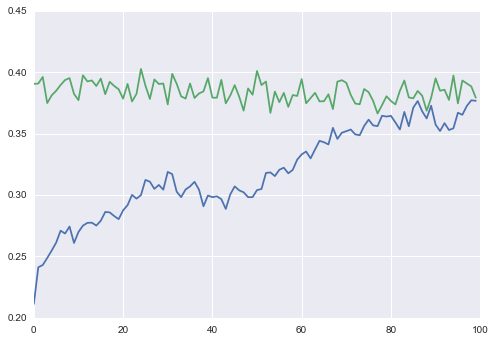

In [56]:
result_arr = np.vstack(new_result)
result_arr_rand = np.vstack(new_result_random)
plt.plot(np.nanmean(result_arr,axis=0))
plt.plot(np.nanmean(result_arr_rand,axis=0))

#result_arr_rand = np.vstack(new_result_random)

In [45]:
result = np.zeros(10)
for rep in xrange(100000):
    last = None
    seq = []
    for x in range(10):
        if not last:
            roll = np.random.choice([1,2,3,4,5,6]) 
            first = roll
        else:
            while roll == last:
                roll = np.random.choice([1,2,3,4,5,6]) 
        seq.append(roll)
        last = roll
    result += (np.array(seq)==first).astype(int)

In [57]:
df.head()

,dist,artist_idx,ts,session,patch_idx_shuffle,block,patch_idx_simple,features
0,NaN,50.0,2007-02-24 22:54:28,0,0,0,0,"[4.91829124712e-08, 9.83658249424e-07, 1.05153..."
1,0.986968,584.0,2007-02-24 22:59:07,0,0,1,1,"[0.00206053967627, 0.00718731389527, 5.2858440..."
2,0.765355,231.0,2007-02-24 23:01:54,0,0,2,2,"[0.0252498142872, 0.00246156047485, 0.00116852..."
3,0.925810,747.0,2007-02-25 01:55:39,0,0,3,3,"[3.00600377109e-07, 3.57113248006e-05, 3.00600..."
4,0.830164,405.0,2007-02-25 02:00:36,0,0,4,4,"[1.79202689245e-07, 0.017360152999, 1.79202689..."
